# Data visualization of CGM data 
- data source: Hall from  https://github.com/irinagain/Awesome-CGM/tree/master
- sample size: 57; 5-minutes intervals; 7 consecutive days at least

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import defaultdict

import pywt
import scaleogram as scg

from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow

from sklearn.metrics import mean_squared_error 

from CGMfunctions import *

## ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
def plotglucosesd(df, sd=1, size=15):
    """
        Plots glucose with specified standard deviation lines
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation lines to plot (default=1)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with standard deviation lines
            
    """
    glucose_mean = np.mean(df['Glucose'])
    up = np.mean(df['Glucose']) + sd*np.std(df['Glucose'])
    dw = np.mean(df['Glucose']) - sd*np.std(df['Glucose'])

    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': size})
    plt.plot(df['Time'], df['Glucose'], '.', color = '#1f77b4')
    plt.axhline(y=glucose_mean, color='red', linestyle='-')
    plt.axhline(y=up, color='pink', linestyle='-')
    plt.axhline(y=dw, color='pink', linestyle='-')
    plt.ylabel('Glucose')
    plt.show()

def plotglucosebounds(df, upperbound = 180, lowerbound = 70, size=15):
    """
        Plots glucose with user-defined boundaries
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            upperbound (integer): user defined upper bound for glucose line to plot (default=180)
            lowerbound (integer): user defined lower bound for glucose line to plot (default=70)
            size (integer): font size for plot (default=15)
        Returns:
            plot of glucose with user defined boundary lines
            
    """
    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': size})
    plt.plot(df['Time'], df['Glucose'], '.', color = '#1f77b4')
    plt.plot(df[df['Glucose']<70]['Time'], df[df['Glucose']<70]['Glucose'], '.', color = 'r')
    plt.axhline(y=upperbound, color='red', linestyle='-')
    plt.axhline(y=lowerbound, color='orange', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Glucose')
    plt.show()


## Import Data

#### Hall 2018 data

In [10]:
# making data frame  
cgm_hall2018 = pd.read_csv("./data/Hall2018_processed.csv",header = 0,index_col=False)  
cgm_hall2018.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
cgm_hall2018.head(5)

id                 Time  Glucose
0  1636-69-001  2014-02-03 03:42:12     93.0
1  1636-69-001  2014-02-03 03:47:12     93.0
2  1636-69-001  2014-02-03 03:52:12     93.0
3  1636-69-001  2014-02-03 03:57:12     95.0
4  1636-69-001  2014-02-03 04:02:12     96.0

In [11]:
cgm_hall2018.id.unique()

array(['1636-69-001', '1636-69-026', '1636-69-028', '1636-69-032',
       '1636-69-035', '1636-69-048', '1636-69-053', '1636-69-060',
       '1636-69-064', '1636-69-069', '1636-69-090', '1636-69-091',
       '1636-69-100', '1636-69-104', '1636-69-107', '1636-69-111',
       '1636-69-114', '1636-69-123', '1636-70-1002', '1636-70-1003',
       '1636-70-1005', '1636-70-1008', '1636-70-1010', '2133-001',
       '2133-002', '2133-003', '2133-004', '2133-006', '2133-007',
       '2133-008', '2133-009', '2133-010', '2133-011', '2133-012',
       '2133-013', '2133-015', '2133-017', '2133-018', '2133-019',
       '2133-020', '2133-021', '2133-022', '2133-023', '2133-024',
       '2133-025', '2133-026', '2133-027', '2133-028', '2133-030',
       '2133-032', '2133-033', '2133-035', '2133-036', '2133-037',
       '2133-039', '2133-040', '2133-041'], dtype=object)

In [9]:
subject_1 = tsalikian2005[tsalikian2005["id"] == 29].reset_index()
subject_1.head(3)

index  id                 Time  Glucose
0  12984  29  2000-03-05 11:33:00      240
1  12985  29  2000-03-05 11:38:00      245
2  12986  29  2000-03-05 11:43:00      246

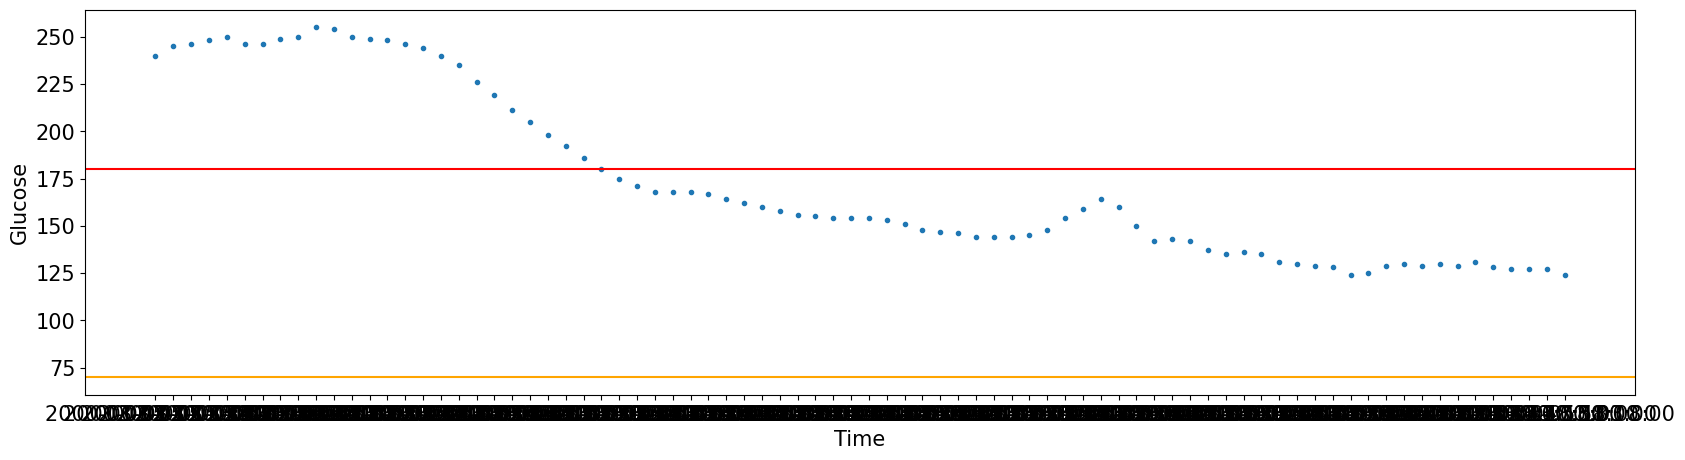

In [11]:
plotglucosebounds(subject_1.iloc[0:80])

### Tsalikian 2005 data
The purpose of this study was to find out how often low blood sugar (hypoglycemia) occurs during the night after exercise in late afternoon for children aged 10 to 18 with type 1 diabetes. The total sample size was 50 participants. The OneTouch Ultra Meter was used to continuously monitor glucose levels during two seperate 24 hours periods. <br>
Sample size: 50 <br>
Diabetes Type: Type 1 <br>
Population Group: Children (10-18) <br>
CGM device: OneTouch Ultra Meter <br>
Duration: 48 hours, every 5 minutes <br> 



In [2]:
tsalikian2005 = pd.read_csv("./data/Tsalikian2005_processed.csv",header = 0,index_col=False)  
tsalikian2005.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
tsalikian2005.head(3)

id                 Time  Glucose
0   7  2000-02-07 12:45:00      107
1   7  2000-02-07 12:50:00      105
2   7  2000-02-07 12:55:00      106

- Find the unique IDs

In [15]:
tsalikian2005.id.unique()

array([ 7, 43,  2, 27, 38, 15, 16, 19, 22, 32, 11,  8, 20, 44, 35, 18, 42,
       17, 36, 46, 33, 48,  5, 53, 14, 40, 13, 41, 25, 26, 28,  3, 50, 29,
       24, 12,  9, 23,  1, 10, 54, 39,  4, 37, 31, 30,  6, 52, 21, 45],
      dtype=int64)

# Andersin2016 Dataset

In [16]:
Anderson2016 = pd.read_csv("./data/Anderson2016_processed.csv",header = 0,index_col=False)  
Anderson2016.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
Anderson2016.head(3)

id                 Time  Glucose
0   1  2013-09-29 17:36:48      194
1   1  2013-09-29 17:41:48      204
2   1  2013-09-29 17:46:48      201

In [17]:
Anderson2016.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 12, 14, 15, 16, 17,
       18, 19, 20, 26, 27, 28, 29, 30, 21, 22, 23, 24, 25], dtype=int64)

### Check time values 

In [223]:
def split_by_subject(df, subject_column):
    # Group the DataFrame by the subject column
    # return the dfs by subject order
    grouped = df.groupby(subject_column)
    
    dfs_by_subject = {}
    
    for subject, group in grouped:
        group = group.reset_index(drop=True)
        dfs_by_subject[subject] = group.copy()
    
    return dfs_by_subject

def check_NAs(df):
    # check all possible NA for the whole dataset
    nan_count = df.isna().sum()
    if nan_count.sum() == 0:
        print("There are no missing values in the dataset.")
    else:
        print("There are missing values in the dataset:")
        for column, count in nan_count.items():
            if count > 0:
                print(f"- {column}: {count} missing values")


def remove_GlucoseNA(df):
    df_cleaned = df.dropna(subset=['Glucose'])
    return df_cleaned

    
def check_time_format(df):
    # check if all the "Time" have the same required time format
    time_series = df['Time']
    time_format = "%Y-%m-%d %H:%M:%S"
    inconsistent_indices = []
    for index, value in time_series.items():
        try:
            # Attempt to parse each value in the Series as a time using the specified format
            pd.to_datetime(value, format=time_format)
        except ValueError:
            inconsistent_indices.append(index)
        
    return inconsistent_indices

def print_wrong_time_records(df,inconsistent_indices):
    # print out the wrong time format records
    print(df.iloc[np.r_[inconsistent_indices],:])

def impute_average_time(df,inconsistent_indices):
    # impute the average time for the wrong formate time records
    time_format = "%Y-%m-%d %H:%M:%S"
    for i in inconsistent_indices:
        max_time =  pd.Timestamp(df['Time'][i-1])
        min_time =  pd.Timestamp(df['Time'][i+1])
        mid_time = ((max_time - min_time) / 2) + min_time
        mid_time = mid_time.strftime(time_format)
        df.at[i, 'Time'] = mid_time

    return df

def rows_with_repeated_values(df, column_name):
    # Identify the repeated values in the specified column
    repeated_values = df[column_name][df[column_name].duplicated(keep=False)]
    
    if repeated_values.empty:
        print("There are no repeated values in the specified column.")
        return pd.DataFrame(columns=df.columns)
    
    # Filter the DataFrame to include only the rows with these repeated values
    df_repeated = df[df[column_name].isin(repeated_values)]
    
    return df_repeated
        
def time_diff_minutes_series(df):
    # check the "Time" difference
    # less4 returns the number of records that the time diff is between 4 and 5, acceptable
    # more6 returns the number of records that the time diff is between 5 and 6, acceptable
    # total returns all the number of records that time diff is not 5 mins
    time_series = df['Time']
    input_format = "%Y-%m-%d %H:%M:%S"
    time_diff_minutes_list = []
    for i in range(1,len(time_series)):
        datetime1 = datetime.strptime(time_series[i-1], input_format)
        datetime2 = datetime.strptime(time_series[i], input_format)
        time_diff = (datetime2 - datetime1).total_seconds() / 60
        time_diff_minutes_list.append(time_diff)

    less4 = sum(4<i<5 for i in time_diff_minutes_list)
    more6 = sum(5<i<6 for i in time_diff_minutes_list)
    total = sum(i != 5 for i in time_diff_minutes_list )
        
    return time_diff_minutes_list,less4,more6,total


def check_missing_time_diff(time_diffs):
    # returns statment of whether there is or not missing time differences
    sum1 = sum(np.isnan(time_diffs))
    if sum1==0:
        print('There is no missing time diffs.')
    else:
        print('There is ',sum1,' missing time diffs.')

def count_records_per_day(df):
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    #df['Date'] = df['Time'].dt.date
    records_per_day = df['Time'].dt.date.value_counts().sort_index()
    records_per_day_df = records_per_day.reset_index()
    records_per_day_df.columns = ['Date', 'Number of Records']
    total_days = sum(records_per_day_df["Number of Records"])
    
    return records_per_day_df,total_days



In [99]:
check_NAs(Anderson2016)
#ttt = check_time_format(tsalikian2005)

There are missing values in the dataset:
- Time: 180 missing values


In [183]:
# split data into a list of dataframe by subject (id) 
# the dataframes ordered by the subject id from small to big
dfs = split_by_subject(tsalikian2005,"id")
subject_1 = dfs[1]


- Select one subject

In [219]:
def find_missing_ranges(df):
    """
    Identify ranges of missing datetime values in the DataFrame.
    """
    missing_ranges = []
    missing_indices = df.index[df['Time'].isna()].tolist()
    if not missing_indices:
        return missing_ranges
    
    start_idx = missing_indices[0]
    end_idx = start_idx
    
    for idx in missing_indices[1:]:
        if idx == end_idx + 1:
            end_idx = idx
        else:
            missing_ranges.append((start_idx, end_idx))
            start_idx = idx
            end_idx = idx
    
    missing_ranges.append((start_idx, end_idx))
    print("Missing time range is ", missing_ranges)
    return missing_ranges

def impute_datetimes(df, freq='5min'):
    time_format = "%Y-%m-%d %H:%M"
    
    missing_ranges = find_missing_ranges(df)
    for start_idx, end_idx in missing_ranges:
        start_time = pd.to_datetime(df.loc[start_idx-1, 'Time'])
        end_time = pd.to_datetime(df.loc[end_idx+1, 'Time'])
        
        # Generate the imputed datetime range
        imputed = pd.date_range(start=start_time, end=end_time, freq=freq)
        
        # Ensure the imputed times have no seconds
        imputed = imputed.to_pydatetime()
        imputed = [ts.replace(second=0, microsecond=0) for ts in imputed]
        imputed = [ts.strftime(time_format) for ts in imputed]
        
        # Apply the imputed times to the missing values
        if len(imputed[1:-1]) == (end_idx - start_idx + 1):
            df.loc[start_idx:end_idx, 'Time'] = imputed[1:-1]
        else:
            print(f"Imputed range for indices {start_idx} to {end_idx} does not match the missing values range. Check the imputation logic.")
    
    return df


test2 = impute_datetimes(subject_1)
test2.iloc[24626:24637,:  ]


id              Time  Glucose
24626   1  2000-04-02 02:00       83
24627   1  2000-04-02 02:05       86
24628   1  2000-04-02 02:10       84
24629   1  2000-04-02 02:15       83
24630   1  2000-04-02 02:20       82
24631   1  2000-04-02 02:25       79
24632   1  2000-04-02 02:30       80
24633   1  2000-04-02 02:35       80
24634   1  2000-04-02 02:40       80
24635   1  2000-04-02 02:45       80
24636   1  2000-04-02 02:50       80

In [176]:
check_NAs(subject_1)
subject_1 = remove_GlucoseNA(subject_1)
subject_1.iloc[164:183,:  ]
#subject_1.iloc[13378:13385,:]

There are no missing values in the dataset.


id                 Time  Glucose
164   1  2000-04-02 01:40:00       71
165   1  2000-04-02 01:45:00       71
166   1  2000-04-02 01:50:00       71
167   1  2000-04-02 01:55:00       73
168   1     2000-04-02 02:00       83
169   1     2000-04-02 02:05       86
170   1     2000-04-02 02:10       84
171   1     2000-04-02 02:15       83
172   1     2000-04-02 02:20       82
173   1     2000-04-02 02:25       79
174   1     2000-04-02 02:30       80
175   1     2000-04-02 02:35       80
176   1     2000-04-02 02:40       80
177   1     2000-04-02 02:45       80
178   1     2000-04-02 02:50       80
179   1     2000-04-02 02:55       73
180   1  2000-04-02 03:00:00       74
181   1  2000-04-02 03:05:00       79
182   1  2000-04-02 03:10:00       81

In [187]:
# if there is no missing time periods
# and impute the datatime values
df1,start, end = records_withmissingtime(subject_1)
#df_nomiss = impute_datetimes(df_gtime,start ,end  )
#df_nomiss.head(3)

There are no missing period in the DataFrame.


In [124]:
# check if the subject_1 all have the same time format
time_check = check_time_format(subject_1)
print_wrong_time_records(subject_1,time_check)

       id        Time  Glucose
13381  17  2013-08-14      229


In [125]:
# impute average time if there is only one missing time
# the dataframe will remain the same if there is no imputed value needed
df_gtime  = impute_average_time(subject_1,time_check)
print_wrong_time_records(df_gtime,time_check)

       id                 Time  Glucose
13381  17  2013-08-14 00:00:00      229


In [220]:
testtt,ttt = count_records_per_day(test2)
print("Records per day:")
print(testtt)

Records per day:
          Date  Number of Records
0   2000-04-01                288
1   2000-04-02                142
2   2000-04-07                298
3   2000-04-08                174
4   2013-09-29                 77
..         ...                ...
93  2014-02-22                 28
94  2014-02-23                287
95  2014-02-24                279
96  2014-02-25                285
97  2014-02-26                 96

[98 rows x 2 columns]


In [107]:
time_diffs,less4, more6,total = time_diff_minutes_series(df_gtime)
check_missing_time_diff(time_diffs)
#print(time_diffs)
print("time diff is more than 5 has ",less4,"time diff is less than 6 has ", more6, "time diff is not 5 has ",total)

There is no missing time diffs.
time diff is more than 5 has  2507 time diff is less than 6 has  1782 time diff is not 5 has  4799


In [221]:
def data_subject_info(df,freq='5min'):
    # print out the basic info of each subject 
    # return the 'good to use' for wavelet transform dataframe list with subject index in order

    print("There are in total ", len(df.id.unique()), "subjects.")
    dfs_good = {}
    dfs_by_subject = split_by_subject(df,"id")
    for subject, df_subject in dfs_by_subject.items():
        print('The information for subject: ', subject)
        subject_1 = df_subject
        check_NAs(subject_1)
        subject_1 = remove_GlucoseNA(subject_1)
        time_check = check_time_format(subject_1)
        df_gtime  = impute_average_time(subject_1,time_check)
        df_nomiss = impute_datetimes(df_gtime,freq=freq )
        records_per_day_df, total_days = count_records_per_day(df_nomiss)
        print("Records per day:")
        print(records_per_day_df)
        print("\nTotal number of days:", total_days)
        dfs_good[subject] = df_gtime.copy()

    return dfs_good


### Check all subjects from one dataset

In [3]:
dfs_good = data_subject_info(tsalikian2005)  #tsalikian2005 #cgm_hall2018

There are in total  50 subjects.
The information for subject:  1
There are missing values in the dataset:
- Time: 24 missing values
Missing time range is  [(168, 179), (24626, 24637)]
Records per day:
          Date  Number of Records
0   2000-04-01                288
1   2000-04-02                144
2   2000-04-07                298
3   2000-04-08                174
4   2013-09-29                 77
..         ...                ...
93  2014-02-22                 28
94  2014-02-23                287
95  2014-02-24                279
96  2014-02-25                285
97  2014-02-26                 96

[98 rows x 2 columns]

Total number of days: 98
The information for subject:  2
There are no missing values in the dataset.
Records per day:
           Date  Number of Records
0    2000-02-06                212
1    2000-02-07                146
2    2000-02-15                298
3    2000-02-16                194
4    2013-08-26                 23
..          ...                ...
247 

In [96]:
test = count_records_per_day(cgm_hall2018[cgm_hall2018["id"]==10])
total_days = sum(test["Number of Records"])
total_days

1801

## Wavelet transform

In [31]:
#print(pywt.families(short=True))

In [32]:
#print(pywt.wavelist(kind='discrete'))

In [284]:
print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


Wavelet transform functions

In [34]:
def lowpassfilter(signal, thresh = 0.5, wavelet="bior2.6"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

def dwt_denoise(signal, wavelet='bior2.6', level=None, thresholding='soft', threshold_value=None):
    coeffs = pywt.wavedec(signal, wavelet, level=level,axis = 0)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    minimax_n = len(coeffs[-1])
    
    if threshold_value is None:
        threshold_value = sigma * np.sqrt(2 * np.log(len(signal)))

    if threshold_value == 'minimax':
        threshold_value = sigma * np.sqrt(2 * np.log(minimax_n))

    def hard_threshold(coeff, thresh):
        return coeff * (np.abs(coeff) >= thresh)
    
    def soft_threshold(coeff, thresh):
        return np.sign(coeff) * np.maximum(np.abs(coeff) - thresh, 0)
    
    def garrote_threshold(coeff, thresh):
        return coeff * (np.abs(coeff) >= thresh) - (thresh**2 / coeff) * (np.abs(coeff) >= thresh)
    
    if thresholding == 'hard':
        threshold_func = hard_threshold
    elif thresholding == 'soft':
        threshold_func = soft_threshold
    elif thresholding == 'garrote':
        threshold_func = garrote_threshold
    else:
        raise ValueError("Invalid thresholding method. Choose 'hard', 'soft', or 'garrote'.")
    
    coeffs[1:] = [threshold_func(c, threshold_value) for c in coeffs[1:]]
    
    denoised_signal = pywt.waverec(coeffs, wavelet)

    if len(denoised_signal) == len(signal):
        return denoised_signal
    else:
        denoised_signal_adj = denoised_signal[:-1]
        return denoised_signal_adj



Metrics functions

In [35]:
def mse(original_signal,reconstructed_signal):
    original = np.asarray(original_signal)
    reconstructed = np.asarray(reconstructed_signal)
    mse = np.mean((original - reconstructed) ** 2)
    return mse
    
def signal_noise_ratio(original_signal,reconstructed_signal):
    signal_power = np.mean(original_signal ** 2)
    noise = original_signal-  reconstructed_signal
    noise_power = np.mean(noise ** 2)
    snr = signal_power / noise_power
    # converts the SNR from a linear scale to decibels.
    snr_db = 10 * np.log10(snr)
    #return snr,snr_db
    return snr_db

def peak_snr(original, reconstructed):
    original = np.asarray(original)
    reconstructed = np.asarray(reconstructed)
    mse = np.mean((original - reconstructed) ** 2)
    
    if mse == 0:
        return float('inf')
    max_pixel_value = np.max(original)
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    return psnr

def get_r2(original, reconstructed):
    original = np.asarray(original)
    reconstructed = np.asarray(reconstructed)
    
    mean_original = np.mean(original)
    ss_tot = np.sum((original - mean_original) ** 2)
    ss_res = np.sum((original - reconstructed) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

def get_metrics(original, reconstructed):
    mse1 = mse(original, reconstructed)
    snr_db = signal_noise_ratio(original, reconstructed)
    psnr = peak_snr(original, reconstructed)
    r2 = get_r2(original, reconstructed)
    
    metrics = {
        'MSE': [mse1],
        'PSNR': [psnr],
        'SNR': [snr_db],
        'R^2': [r2]
    }
    df_metrics = pd.DataFrame(metrics)
    
    return df_metrics

def get_all_metrics(original,denoised_hard,denoised_soft,denoised_garrote):
    df_hard = get_metrics(original,denoised_hard)
    df_soft = get_metrics(original,denoised_soft)
    df_garrote = get_metrics(original,denoised_garrote)
    df_all_metrics = pd.concat([df_hard, df_soft,df_garrote], axis=0)
    df_all_metrics['thresh'] = ['hard','soft','garrote']
    
    return df_all_metrics

def find_best_metrics(df):
    metrics = []
    best_values = []
    names = []
    threshs = []
    
    for metric in ['MSE', 'PSNR', 'SNR', 'R^2']:
        if metric in ['PSNR', 'SNR','R^2']:
            value = df[metric].max()
            name = df.loc[df[metric].idxmax(), 'name']
            thresh = df.loc[df[metric].idxmax(), 'thresh']
        else:
            value = df[metric].min()
            name = df.loc[df[metric].idxmin(), 'name']
            thresh = df.loc[df[metric].idxmax(), 'thresh']
        metrics.append(metric)
        best_values.append(value)
        names.append(name)
        threshs.append(thresh)
    
    results_df = pd.DataFrame({
        'Metric': metrics,
        'Value': best_values,
        'Name': names,
        'Thresh': threshs
    })
    return results_df

def best_parameter(results_df):
    name = results_df['Name'][0]
    parts = name.split('_')
    best_wavelet = parts[0]
    best_level = int(parts[2])
    return best_wavelet, best_level
    

def plot_compare(original, reconstructed):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(original,linewidth=2, label='original signal',alpha = 0.8)
    ax.plot(reconstructed, label='DWT denoised', linewidth=2,linestyle='--')
    #ax.scatter(x=t,y=original,s=5, label='original signal',marker = 'o')
    #ax.scatter(x=t,y=reconstructed, label='DWT denoised', s=5,marker='v')
    ax.legend()
    ax.set_title('Denoising CGM with DWT', fontsize=18)
    ax.set_ylabel('Glucose', fontsize=16)
    ax.set_xlabel('Time', fontsize=16)
    plt.axhline(y=70, color='red', linestyle='-')
    plt.axhline(y=180, color='orange', linestyle='-')
    plt.legend(loc='upper right',fontsize=10)
    plt.show()
    

In [36]:

def get_best_parameters_allsubject(dfs_good,wavelet_candidates,level_candidates):
    # return the dataframe listing all subjects' best wavelet and best level
    # return a dict of dataframe for each subject showing all detailed results
    
    allsubject_metrics_dict = {}
    best_parameter_dict = {}
    
    for subject, df_good in dfs_good.items():
        original_signal = df_good['Glucose'].values
        t =  df_good['Time'].values
        metrics_dict = {}
        for wavelet_choice in wavelet_candidates:
            for level_choice in level_candidates:
                denoised_hard = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='hard')
                denoised_soft = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='soft')
                denoised_garrote = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='garrote')
                name = wavelet_choice +'_level_' + str(level_choice)
                #metrics_dict[name] = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote)
                df = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote) #[:-1]
                df['name'] = name
                metrics_dict[name] = df
        
        metrics_allresults = pd.concat(metrics_dict.values(), ignore_index=True)
        compare_df = find_best_metrics(metrics_allresults)
        compare_df['subject'] = subject
        allsubject_metrics_dict[subject] = compare_df
        best_wavelet, best_level = best_parameter(compare_df)
        best_parameter_dict[subject] = pd.DataFrame({ 'wavelet': [best_wavelet],'level': [best_level],'subject': [subject]})
    
    metrics_allsubjects = pd.concat(allsubject_metrics_dict.values(), ignore_index=True)
    best_parameters_all = pd.concat(best_parameter_dict.values(), ignore_index=True)

    return  best_parameters_all, allsubject_metrics_dict

def get_best_parameters_onesub(df_good,wavelet_candidates,level_candidates):
    # return one dataframe for one subject of the best wavelet and level
    # return one big dataframe showing all the result for different combinations
    
    original_signal = df_good['Glucose'].values
    t =  df_good['Time'].values
    metrics_dict_one = {}
    for wavelet_choice in wavelet_candidates:
        for level_choice in level_candidates:
            denoised_hard = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='hard')
            denoised_soft = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='soft')
            denoised_garrote = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='garrote')
            name = wavelet_choice +'_level_' + str(level_choice)
            #metrics_dict[name] = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote)
            df = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote) #[:-1]
            df['name'] = name
            metrics_dict_one[name] = df
    
    metrics_allresults = pd.concat(metrics_dict_one.values(), ignore_index=True)
    compare_df = find_best_metrics(metrics_allresults)
    
    return compare_df, metrics_allresults
        

In [37]:
wavelet_candidates = ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7',
                          'bior3.9', 'bior4.4','coif2','coif10', 'coif16','db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11',
                          'db12', 'db15', 'db25',  'haar', 'rbio1.5', 'rbio3.1', 'rbio6.8']
level_candidates = [2,3,4,5]

set the original signal

In [38]:
###### start ######
df_good = dfs_good['2133-041']
original_signal = df_good['Glucose'].values
t =  df_good['Time'].values
df_good.head(3)

id                 Time  Glucose
0  2133-041  2017-07-03 18:32:06    143.0
1  2133-041  2017-07-03 18:37:06    141.0
2  2133-041  2017-07-03 18:42:06    134.0

In [39]:
# check the max level of decomposition
import pywt
w = pywt.Wavelet('db10')
# print(pywt.dwt_max_level(data_len=len(dfs_good[1]), filter_len=w.dec_len))
print(pywt.dwt_max_level(data_len=900, filter_len=w.dec_len))

5


try diffrent way to denoise signal

In [40]:
wavelet_choice = 'bior2.6' #wavelet_candidates[3]
level_choice = 3 # level_candidates[1]
denoised_hard = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='hard')
denoised_soft = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='soft')
denoised_garrote = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='garrote')

In [41]:
#df1 = get_all_metrics(original_signal,denoised_hard[:-1],denoised_soft[:-1],denoised_garrote[:-1])
df1 = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote)
df1

MSE       PSNR        SNR       R^2   thresh
0  0.526053  48.982307  43.675508  0.998898     hard
0  1.648451  44.021844  38.715044  0.996546     soft
0       NaN        NaN        NaN       NaN  garrote

In [42]:
# Warnings
# C:\Users\Tong.Qi\AppData\Local\Temp\1\ipykernel_18960\1721270531.py:26: RuntimeWarning: divide by zero encountered in divide
#   return coeff * (np.abs(coeff) >= thresh) - (thresh**2 / coeff) * (np.abs(coeff) >= thresh)
# C:\Users\Tong.Qi\AppData\Local\Temp\1\ipykernel_18960\1721270531.py:26: RuntimeWarning: invalid value encountered in multiply
#   return coeff * (np.abs(coeff) >= thresh) - (thresh**2 / coeff) * (np.abs(coeff) >= thresh)
# C:\Users\Tong.Qi\AppData\Roaming\Python\Python312\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
#   warnings.warn(
# C:\Users\Tong.Qi\AppData\Roaming\Python\Python312\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.

In [43]:
one_df, one_allresult = get_best_parameters_onesub(df_good,wavelet_candidates,level_candidates)

In [44]:
one_df

Metric      Value             Name Thresh
0    MSE   0.501316  bior2.8_level_2   soft
1   PSNR  49.191484  bior2.8_level_2   hard
2    SNR  43.884684  bior2.8_level_2   hard
3    R^2   0.998949  bior2.8_level_2   hard

In [45]:
all_df,all_dict = get_best_parameters_allsubject(dfs_good,wavelet_candidates,level_candidates)

In [17]:
# all_df

In [47]:
# ############## Get all the results
# metrics_dict = {}
# for wavelet_choice in wavelet_candidates:
#     for level_choice in level_candidates:
#         denoised_hard = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='hard')
#         denoised_soft = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='soft')
#         denoised_garrote = dwt_denoise(original_signal,wavelet=wavelet_choice, level=level_choice, thresholding='garrote')
#         name = wavelet_choice +'_level_' + str(level_choice)
#         #metrics_dict[name] = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote)
#         #df = get_all_metrics(original_signal,denoised_hard[:-1],denoised_soft[:-1],denoised_garrote[:-1]) #[:-1]
#         df = get_all_metrics(original_signal,denoised_hard,denoised_soft,denoised_garrote) #[:-1]
#         df['name'] = name
#         metrics_dict[name] = df

# metrics_allresults = pd.concat(metrics_dict.values(), ignore_index=True)

In [15]:
#print(metrics_allresults)

In [49]:
##### return the best results
compare_df = find_best_metrics(one_allresult)
print(compare_df)

  Metric      Value             Name Thresh
0    MSE   0.501316  bior2.8_level_2   soft
1   PSNR  49.191484  bior2.8_level_2   hard
2    SNR  43.884684  bior2.8_level_2   hard
3    R^2   0.998949  bior2.8_level_2   hard


In [50]:
best_wavelet, best_level = best_parameter(one_df)
print(best_wavelet,best_level)
final_reconstructed = dwt_denoise(original_signal,wavelet=best_wavelet, level=best_level, thresholding='hard')

bior2.8 2


In [51]:
df_good.head(2)

id                 Time  Glucose
0  2133-041  2017-07-03 18:32:06    143.0
1  2133-041  2017-07-03 18:37:06    141.0

In [52]:
plot_compare_zoom(df_good, final_reconstructed)

NameError: name 'plot_compare_zoom' is not defined

In [53]:
interactive_compare(df_good,final_reconstructed)

NameError: name 'interactive_compare' is not defined

Plots

In [241]:
def plot_compare_zoom(df,final_reconstructed):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    original_signal = df['Glucose'].values
    # x =  df['Time'].values
    x = np.arange(len(df['Time']))
    signal1 = original_signal
    signal2 = final_reconstructed
    
    difference = np.abs(signal1 - signal2)

    max_diff_index = np.argmax(difference)
    
    window_size = 30  # Number of points to include around the max difference
    start_index = max(0, max_diff_index - window_size // 2)
    end_index = min(len(x), max_diff_index + window_size // 2)
    
    # Plot the original signals
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, signal1, label='Original Signal',linewidth = 2, marker='o',markersize = 2)
    ax.plot(x, signal2, label='Reconstructed Signal',linewidth=2,linestyle='--', marker='v',markersize=2)
    plt.axhline(y=70, color='red', linestyle='-')
    plt.axhline(y=180, color='orange', linestyle='-')
    
    # Highlight the region with the maximum difference
    #ax.axvspan(x[start_index], x[end_index], color='yellow', alpha=0.3, label='Zoomed Area')
    
    # plot the zoomed area
    ax_inset = inset_axes(ax, width="20%", height="30%", loc="upper right")
    ax_inset.plot(x, signal1, label='Original Signal',marker='o',markersize = 2)
    ax_inset.plot(x, signal2, label='Reconstructed Signal',linestyle = "--", marker='v',markersize = 2)
    ax_inset.set_xlim(x[start_index], x[end_index])
    ax_inset.set_ylim(min(signal1[start_index:end_index].min(), signal2[start_index:end_index].min()) - 0.1,
                      max(signal1[start_index:end_index].max(), signal2[start_index:end_index].max()) + 0.1)
    ax_inset.set_title('Zoomed Area')
    plt.gca().set_xticks([])

    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

    ax.legend()
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Glucose',fontsize = 12)
    ax.set_title(f'Denoising CGM with DWT for subject {df["id"][0]}',fontsize = 14)
    ax.legend(loc='lower left',fontsize=10)
    
    plt.show()


In [55]:
def interactive_compare(df,final_reconstructed):
    import numpy as np
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.layouts import column
    from bokeh.models import BoxZoomTool, ResetTool
    from bokeh.models import Span
    
    # Enable output in the notebook
    output_notebook()
    
    # Generate some sample data
    original_signal = df['Glucose'].values
    signal1 = original_signal
    signal2 = final_reconstructed
    x = np.linspace(0, len(signal1),len(signal1))
    
    # Create a figure
    p = figure(title=f'Denoising CGM with DWT Interactive Plot for subject {df["id"][0]}', x_axis_label='Time', y_axis_label='Glucose',
               tools="pan,wheel_zoom,box_zoom,reset", active_drag="box_zoom",width =800,height=350,background_fill_color="#fafafa")
    
    # Add the signals to the plot
    p.line(x, signal1, legend_label="Original Signal", line_width=2, color="#2ca02c")
    p.scatter(x, signal1,line_color ='#2ca02c', fill_color="#2ca02c", size=3)
    p.line(x, signal2, legend_label="Reconstructed Signal", line_width=2, color="#ff7f0e")
    p.scatter(x, signal2,line_color ='#ff7f0e', fill_color="#ff7f0e", size=3)

    dst_low = Span(location=70, dimension='width',line_color='red', line_width=2)
    dst_high = Span(location=180, dimension='width',line_color='orange', line_width=2)
    p.add_layout(dst_low)
    p.add_layout(dst_high)

    # Add BoxZoom and Reset tools
    p.add_tools(BoxZoomTool(), ResetTool())
    
    # Show the plot
    show(p)


In [251]:
def interactive_compare_three(df,noisy_df,final_reconstructed,):
    import numpy as np
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.layouts import column
    from bokeh.models import BoxZoomTool, ResetTool
    from bokeh.models import Span
    
    # Enable output in the notebook
    output_notebook()
    
    # Generate some sample data
    original_signal = df['Glucose'].values
    signal1 = original_signal
    signal2 = final_reconstructed
    noisysignal = noisy_df['Glucose'].values
    x = np.linspace(0, len(signal1),len(signal1))
    
    # Create a figure
    p = figure(title=f'Denoising CGM with DWT Interactive Plot for subject {df["id"][0]}', x_axis_label='Time', y_axis_label='Glucose',
               tools="pan,wheel_zoom,box_zoom,reset", active_drag="box_zoom",width =800,height=350,background_fill_color="#fafafa")
    
    # Add the signals to the plot
    p.line(x, noisysignal, legend_label="Noisy Signal", line_width=2, color="khaki")
    p.scatter(x, noisysignal,line_color ='khaki', fill_color="khaki", size=3)
    p.line(x, signal1, legend_label="Original Signal", line_width=2, color="#2ca02c")
    p.scatter(x, signal1,line_color ='#2ca02c', fill_color="#2ca02c", size=3)
    p.line(x, signal2, legend_label="Reconstructed Signal", line_width=2, color="#ff7f0e")
    p.scatter(x, signal2,line_color ='#ff7f0e', fill_color="#ff7f0e", size=3)


    dst_low = Span(location=70, dimension='width',line_color='red', line_width=2)
    dst_high = Span(location=180, dimension='width',line_color='orange', line_width=2)
    p.add_layout(dst_low)
    p.add_layout(dst_high)

    # Add BoxZoom and Reset tools
    p.add_tools(BoxZoomTool(), ResetTool())
    
    # Show the plot
    show(p)

## Separate into daily data start from dfs_good

In [57]:
def split_by_date(dfs_good):
    # Dictionary to store the DataFrames by date
    date_dfs = {}

    # Iterate through each DataFrame in the dictionary
    for subject, df in dfs_good.items():
        # Ensure the datetime column is in datetime format
        df['Time'] = pd.to_datetime(df['Time'])

        # Group the DataFrame by date
        grouped = df.groupby(df['Time'].dt.date)

        # Iterate through each group and store the resulting DataFrames in the dictionary
        for date, group in grouped:
            if date not in date_dfs:
                date_dfs[date] = {}
            date_dfs[date][subject] = group.reset_index(drop=True)

    return date_dfs

def get_df_by_subject(date_dfs, subject):
    subject_df_list = []
    for date, subject_dict in date_dfs.items():
        if subject in subject_dict:
            subject_df_list.append(subject_dict[subject])
    if subject_df_list:
        return pd.concat(subject_df_list, ignore_index=True)
    else:
        print(f"No data found for subject: {subject}")
        return None
        

def get_best_parameters_allsubject_alldates(dfs_good, wavelet_candidates, level_candidates):
    # Split by date
    date_dfs = split_by_date(dfs_good)

    # Containers for results
    allsubject_metrics_dict = {}
    best_parameter_dict = {}

    # Iterate over dates
    for date, subject_dfs in date_dfs.items():
        for subject, df_good in subject_dfs.items():
            original_signal = df_good['Glucose'].values
            t = df_good['Time'].values
            metrics_dict = {}

            for wavelet_choice in wavelet_candidates:
                for level_choice in level_candidates:
                    denoised_hard = dwt_denoise(original_signal, wavelet=wavelet_choice, level=level_choice, thresholding='hard')
                    denoised_soft = dwt_denoise(original_signal, wavelet=wavelet_choice, level=level_choice, thresholding='soft')
                    denoised_garrote = dwt_denoise(original_signal, wavelet=wavelet_choice, level=level_choice, thresholding='garrote')
                    name = f'{wavelet_choice}_level_{level_choice}'
                    df = get_all_metrics(original_signal, denoised_hard, denoised_soft, denoised_garrote)
                    df['name'] = name
                    metrics_dict[name] = df

            metrics_allresults = pd.concat(metrics_dict.values(), ignore_index=True)
            compare_df = find_best_metrics(metrics_allresults)
            compare_df['subject'] = subject
            compare_df['date'] = date

            if subject not in allsubject_metrics_dict:
                allsubject_metrics_dict[subject] = []
            allsubject_metrics_dict[subject].append(compare_df)

            best_wavelet, best_level = best_parameter(compare_df)
            if subject not in best_parameter_dict:
                best_parameter_dict[subject] = []
            best_parameter_dict[subject].append(pd.DataFrame({'wavelet': [best_wavelet], 'level': [best_level], 'subject': [subject], 'date': [date]}))

    # Combine results
    for subject in allsubject_metrics_dict:
        allsubject_metrics_dict[subject] = pd.concat(allsubject_metrics_dict[subject], ignore_index=True)
    best_parameters_all = pd.concat([pd.concat(value) for value in best_parameter_dict.values()], ignore_index=True)

    return best_parameters_all, allsubject_metrics_dict


In [58]:
all_date_dfs = split_by_date(dfs_good) 
try_date = pd.to_datetime('2014-02-03').date()
all_date_dfs[try_date]['1636-69-001']

id                Time  Glucose
0    1636-69-001 2014-02-03 03:42:12     93.0
1    1636-69-001 2014-02-03 03:47:12     93.0
2    1636-69-001 2014-02-03 03:52:12     93.0
3    1636-69-001 2014-02-03 03:57:12     95.0
4    1636-69-001 2014-02-03 04:02:12     96.0
..           ...                 ...      ...
239  1636-69-001 2014-02-03 23:37:08     82.0
240  1636-69-001 2014-02-03 23:42:07     83.0
241  1636-69-001 2014-02-03 23:47:07     84.0
242  1636-69-001 2014-02-03 23:52:07     85.0
243  1636-69-001 2014-02-03 23:57:07     86.0

[244 rows x 3 columns]

In [59]:
allbydate_df, allbydate_dict = get_best_parameters_allsubject_alldates(dfs_good,wavelet_candidates, level_candidates)


In [61]:
print(allbydate_dict['2133-041'])

   Metric      Value             Name Thresh   subject        date
0     MSE   0.761110  bior3.7_level_2   soft  2133-041  2017-07-03
1    PSNR  44.292245  bior3.7_level_2   hard  2133-041  2017-07-03
2     SNR  41.766159  bior3.7_level_2   hard  2133-041  2017-07-03
3     R^2   0.997128  bior3.7_level_2   hard  2133-041  2017-07-03
4     MSE   0.343025  bior2.6_level_2   soft  2133-041  2017-07-04
5    PSNR  47.631120  bior2.6_level_2   hard  2133-041  2017-07-04
6     SNR  45.840120  bior2.6_level_2   hard  2133-041  2017-07-04
7     R^2   0.997220  bior2.6_level_2   hard  2133-041  2017-07-04
8     MSE   0.113796  bior3.9_level_2   soft  2133-041  2017-07-05
9    PSNR  53.245367  bior3.9_level_2   hard  2133-041  2017-07-05
10    SNR  51.156075  bior3.9_level_2   hard  2133-041  2017-07-05
11    R^2   0.999338  bior3.9_level_2   hard  2133-041  2017-07-05
12    MSE   0.501381  bior3.9_level_2   soft  2133-041  2017-07-06
13   PSNR  46.462042  bior3.9_level_2   hard  2133-041  2017-0

In [62]:
dfs_good['2133-041']['Time'] = dfs_good['2133-041']['Time'].astype(str)
records_per_day_df, total_days = count_records_per_day(dfs_good['2133-041'])
print("Records per day:")
print(records_per_day_df)
print("\nTotal number of days:", total_days)

Records per day:
         Date  Number of Records
0  2017-07-03                 66
1  2017-07-04                286
2  2017-07-05                110
3  2017-07-06                288
4  2017-07-07                288
5  2017-07-08                249
6  2017-07-09                285
7  2017-07-10                115
8  2017-07-11                171

Total number of days: 9


# add noise 

In [63]:
print(cgm_hall2018.id.unique())
dfs = split_by_subject(cgm_hall2018,"id")
subject_1 = dfs['1636-69-001']

['1636-69-001' '1636-69-026' '1636-69-028' '1636-69-032' '1636-69-035'
 '1636-69-048' '1636-69-053' '1636-69-060' '1636-69-064' '1636-69-069'
 '1636-69-090' '1636-69-091' '1636-69-100' '1636-69-104' '1636-69-107'
 '1636-69-111' '1636-69-114' '1636-69-123' '1636-70-1002' '1636-70-1003'
 '1636-70-1005' '1636-70-1008' '1636-70-1010' '2133-001' '2133-002'
 '2133-003' '2133-004' '2133-006' '2133-007' '2133-008' '2133-009'
 '2133-010' '2133-011' '2133-012' '2133-013' '2133-015' '2133-017'
 '2133-018' '2133-019' '2133-020' '2133-021' '2133-022' '2133-023'
 '2133-024' '2133-025' '2133-026' '2133-027' '2133-028' '2133-030'
 '2133-032' '2133-033' '2133-035' '2133-036' '2133-037' '2133-039'
 '2133-040' '2133-041']


In [64]:
wavelet_candidates = ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7',
                          'bior3.9', 'bior4.4','coif2','coif10', 'coif16','db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11',
                          'db12', 'db15', 'db25',  'haar', 'rbio1.5', 'rbio3.1', 'rbio6.8']
level_candidates = [2,3,4,5]

In [65]:
def add_noise_to_glucose(df, sigma):
    noisy_df = df.copy()
    noise = np.random.normal(0, sigma, noisy_df['Glucose'].shape)
    noisy_df['Glucose'] += noise
    return noisy_df

def add_noise_to_all_dfs(df_list, sigma):
    noisy_dfs_dict = {}
    for subject, df_good in df_list.items():
        noisy_df = add_noise_to_glucose(df_good, sigma)
        noisy_dfs_dict[subject] = noisy_df
    return noisy_dfs_dict

#sigma * np.random.randn(...) + mu is same as np.random.normal(loc= mu, scale= sigma, ...)

In [228]:
noisy_dfs = add_noise_to_all_dfs(dfs_good, 8)

In [229]:
all__noise_df,all_noise_dict = get_best_parameters_allsubject(noisy_dfs,wavelet_candidates,level_candidates)

In [253]:
#all__noise_df

In [236]:
df_good = dfs_good[1]
df_noise = noisy_dfs[1]
one_df, one_allresult = get_best_parameters_onesub(df_noise,wavelet_candidates,level_candidates)
one_df

Metric      Value             Name Thresh
0    MSE  53.459139  bior3.9_level_2   soft
1   PSNR  35.086248  bior3.9_level_2   hard
2    SNR  27.383021  bior3.9_level_2   hard
3    R^2   0.982510  bior3.9_level_2   hard

In [237]:
best_wavelet, best_level = best_parameter(one_df)
print(best_wavelet,best_level)
final_reconstructed = dwt_denoise(df_noise["Glucose"],wavelet=best_wavelet, level=best_level, thresholding='hard')

bior3.9 2


In [238]:
mse(df_good['Glucose'],final_reconstructed)

25.858438830913894

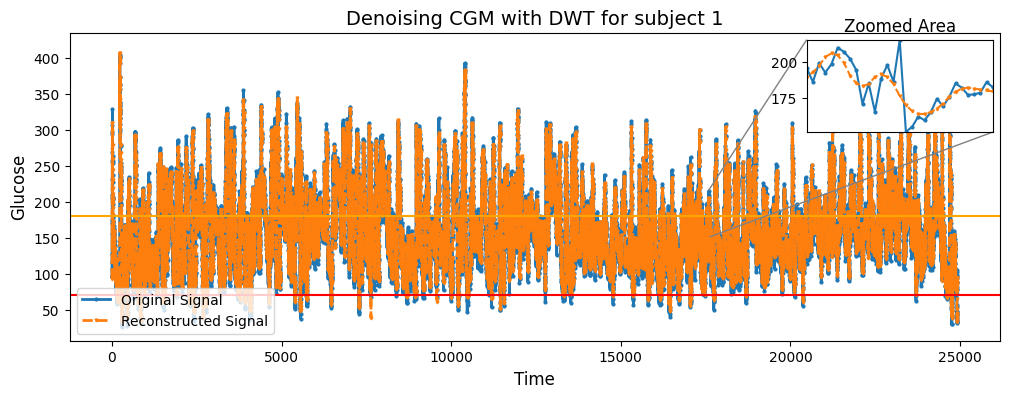

In [242]:
plot_compare_zoom(df_noise, final_reconstructed)

In [243]:
interactive_compare(df_noise,final_reconstructed)

Loading BokehJS ...

In [252]:
df_good = dfs_good[1]
df_noise = noisy_dfs[1]
interactive_compare_three(df_good,df_noise,final_reconstructed)

Loading BokehJS ...

In [282]:
### investigate the coefficients
coeffs = pywt.wavedec(signal, 'bior3.9', level=8)
print(len(signal))
print(len(coeffs))
print(len(coeffs[0]))
print(len(coeffs[1]))
print(len(coeffs[2]))
print(len(coeffs[3]))
print(len(coeffs[4]))


1846
9
26
26
33
47
76


In [283]:
signal

0        93.0
1        93.0
2        93.0
3        95.0
4        96.0
        ...  
1841    115.0
1842    114.0
1843    117.0
1844    121.0
1845    119.0
Name: Glucose, Length: 1846, dtype: float64

# clean the records with time chunks with repeated time range

In [ ]:
dfs_good = data_subject_info(tsalikian2005)  #tsalikian2005 #cgm_hall2018

In [13]:
all_date_dfs = split_by_date_allsub(dfs_good) 
try_date = pd.to_datetime('2014-09-27').date()
test = all_date_dfs[try_date][8]
print(test.shape)
print(test.head(3))

(280, 3)
   id                Time  Glucose
0   8 2014-09-27 00:00:40      250
1   8 2014-09-27 00:05:40      234
2   8 2014-09-27 00:10:40      215


In [22]:
def crossover_timechunk(df):
    break_indices = [0]  # Start with the first row
    for i in range(1, len(df)):
        if df['Time'][i] < df['Time'][i - 1]:
            break_indices.append(i)
    break_indices.append(len(df))  
    dfs = []
    for idx in range(len(break_indices) - 1):
        part = df.iloc[break_indices[idx]:break_indices[idx + 1]].copy()
        if idx > 0: 
            part['id'] = part['id'].astype(str) + f"_{idx + 1}"
        dfs.append(part)
    return dfs
 
def split_crossover_timechunk(df_dicts):
    split_dict = {}
    for date, date_dfs in df_dicts.items():
        middle_dict = {}
        for subject, df in date_dfs.items():
            final_df = crossover_timechunk(df)
            middle_dict[subject] = final_df
        split_dict[date] = middle_dict
    return split_dict

In [23]:
test_chunk_dict = split_crossover_timechunk(all_date_dfs)

## test

In [16]:
Wx, scales2 = cwt(signal, 'cmhat')  #`wavelet` must be one of: bump, gmw, cmhat, hhhat, morlet (got cmor1.5-1.0)
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

NameError: name 'signal' is not defined